In [1]:
# Загрузим архив с изображениями
!wget http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishImg.tgz

--2023-08-27 18:48:30--  http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishImg.tgz
Resolving www.ee.surrey.ac.uk (www.ee.surrey.ac.uk)... 131.227.80.48
Connecting to www.ee.surrey.ac.uk (www.ee.surrey.ac.uk)|131.227.80.48|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133975105 (128M) [application/x-gzip]
Saving to: ‘EnglishImg.tgz’

EnglishImg.tgz      100%[===================>] 127.77M  29.4MB/s    in 4.9s    

2023-08-27 18:48:36 (25.9 MB/s) - ‘EnglishImg.tgz’ saved [133975105/133975105]



In [2]:
# распакуем архив
!tar -xvzf EnglishImg.tgz

Выходные данные были обрезаны до нескольких последних строк (5000).
English/Img/GoodImg/Msk/Sample013/img013-00068.png
English/Img/GoodImg/Msk/Sample013/img013-00069.png
English/Img/GoodImg/Msk/Sample013/img013-00070.png
English/Img/GoodImg/Msk/Sample013/img013-00071.png
English/Img/GoodImg/Msk/Sample013/img013-00072.png
English/Img/GoodImg/Msk/Sample013/img013-00074.png
English/Img/GoodImg/Msk/Sample013/img013-00075.png
English/Img/GoodImg/Msk/Sample013/img013-00076.png
English/Img/GoodImg/Msk/Sample013/img013-00077.png
English/Img/GoodImg/Msk/Sample013/img013-00078.png
English/Img/GoodImg/Msk/Sample013/img013-00079.png
English/Img/GoodImg/Msk/Sample013/img013-00080.png
English/Img/GoodImg/Msk/Sample013/img013-00081.png
English/Img/GoodImg/Msk/Sample013/img013-00082.png
English/Img/GoodImg/Msk/Sample013/img013-00083.png
English/Img/GoodImg/Msk/Sample013/img013-00084.png
English/Img/GoodImg/Msk/Sample013/img013-00085.png
English/Img/GoodImg/Msk/Sample013/img013-00086.png
English/Img/Go

In [3]:
#импортируем библиотеки
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import numpy as np
import math
import os
from shutil import copyfile
from tqdm import tqdm

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape,Dense,Flatten, Activation, Dropout, BatchNormalization, MaxPooling2D,InputLayer

from sklearn.metrics import classification_report

**Подготовка данных**

In [4]:
# Создадим список с именами классов.
class_name = []

for i in range(ord('0'), ord('9')+1):
    class_name.append(chr(i))

for i in range(ord('A'), ord('Z')+1):
    class_name.append(chr(i))

for i in range(ord('a'), ord('z')+1):
    class_name.append(chr(i))

In [5]:
# Создадим дирректории для выборок train, test и validation.

if not os.path.isdir('dataset'):
  os.mkdir('dataset')

if not os.path.isdir('dataset/train'):
  os.mkdir('dataset/train')
if not os.path.isdir('dataset/valid'):
  os.mkdir('dataset/valid')
if not os.path.isdir('dataset/test'):
  os.mkdir('dataset/test')

In [6]:
for i in sorted(os.listdir('English/Img/GoodImg/Bmp')):
  if not os.path.isdir('dataset/train/'+i):
    os.mkdir('dataset/train/'+i)
  if not os.path.isdir('dataset/valid/'+i):
    os.mkdir('dataset/valid/'+i)
  if not os.path.isdir('dataset/test/'+i):
    os.mkdir('dataset/test/'+i)

In [7]:
# Распределеим фотографии с изображениями по созданным дирректориям.
# Рапределение изображений разных классов по папкам необходимо для
# использования ImageDataGenerator.

base = 'English/Img/GoodImg/Bmp/Sample'
target_train = 'dataset/train/Sample'
target_test = 'dataset/test/Sample'
target_valid = 'dataset/valid/Sample'
randTrain_count=0
randValid_count=0
randTest_count=0

np.random.seed(25)

# Выборка содержит изображения символов (0-9,A-Z,a-z). В общей сложности - 62 класса.
for char  in tqdm(range(1, 63)):
  classLen = len(os.listdir(base + str(char).zfill(3)))

# Размер тренировочной выборки = 80%,
#        валидационной 15%
#           тестовой = 5%.
  trainLen = math.floor(classLen*0.80)
  validLen = math.ceil(classLen*0.15)

  randFnt = np.random.randint(low = 1, high = classLen, size = classLen)

  randTrain = randFnt[:trainLen]
  randValid = randFnt[trainLen : trainLen+validLen]
  randTest = randFnt[trainLen+validLen :]

  randTrain_count+=len(randTrain)
  randValid_count+=len(randValid)
  randTest_count+=len(randTest)

  for imgNo in randTrain:
    end_path = f"{char:03d}/img{char:03d}-{imgNo:05d}.png"
    src = base + end_path
    des = target_train + end_path
    copyfile(src, des)

  for imgNo in randValid:
    end_path = f"{char:03d}/img{char:03d}-{imgNo:05d}.png"
    src = base + end_path
    des = target_valid + end_path
    copyfile(src, des)

  for imgNo in randTest:
    end_path = f"{char:03d}/img{char:03d}-{imgNo:05d}.png"
    src = base + end_path
    des = target_test + end_path
    copyfile(src, des)

100%|██████████| 62/62 [00:00<00:00, 65.99it/s]


In [8]:
print('Размер выборок:')
print(f'Train: {randTrain_count}')
print(f'Test: {randTest_count}')
print(f'Valid: {randValid_count}')

Размер выборок:
Train: 6140
Test: 378
Valid: 1187


In [9]:
num_classes = 62
image_resize = 128
batch_size_training = 16
batch_size_validation = 16

**Инициализация ImageDataGenerator**

In [10]:
data_generator = ImageDataGenerator(rescale=1.0/255.0)

train_generator = data_generator.flow_from_directory(
    'dataset/train',
    target_size = (image_resize, image_resize),
    batch_size = batch_size_training,
    # color_mode = 'grayscale',
    class_mode = 'categorical'
)

test_generator = data_generator.flow_from_directory(
    'dataset/test',
    target_size = (image_resize, image_resize),
    batch_size = batch_size_validation,
    # color_mode = 'grayscale',
    class_mode = 'categorical'
)

validation_generator = data_generator.flow_from_directory(
    'dataset/valid',
    target_size = (image_resize, image_resize),
    batch_size = batch_size_validation,
    # color_mode = 'grayscale',
    class_mode = 'categorical'
)

Found 4196 images belonging to 62 classes.
Found 370 images belonging to 62 classes.
Found 1096 images belonging to 62 classes.


In [11]:
def show_images(images,labels_ind, true_ind=None):
    num_of_images = len(images)

    fig, axes = plt.subplots(1, num_of_images,
            figsize=(3 * num_of_images, 3 * num_of_images) # Размер изображений будет зависет от из к-ва в строке.
            )

    for i, (image_pixels,label_ind) in enumerate(zip(images,labels_ind)):

        title_text = class_name[np.argmax(label_ind)]
        if true_ind is not None:
            title_text+=f' true = {class_name[np.argmax(true_ind[i])]}'

        axes[i].imshow(image_pixels)
        axes[i].title.set_text(title_text)

In [12]:
# Проверим работу генератора.

batchX, batchy = train_generator.next()

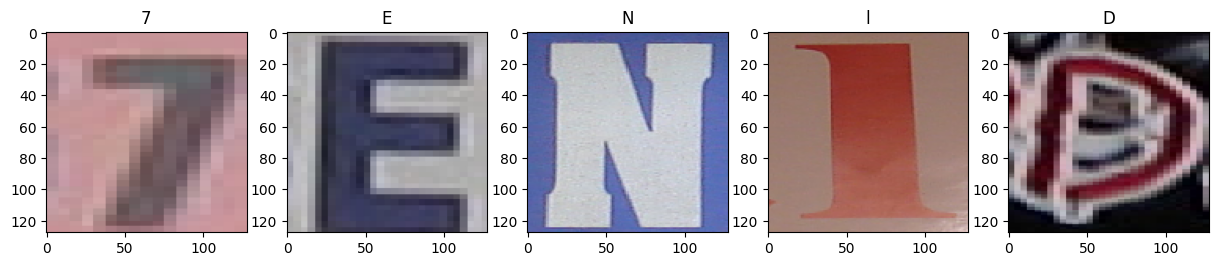

In [13]:
show_images(batchX[0:5], batchy[0:5])

**Строим модель**

In [14]:
# конфигурирование слоев нейросети
model = Sequential()

model.add(InputLayer(input_shape = (128, 128, 3)))

model.add(Conv2D(filters=32, kernel_size=3,activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=3,activation='relu', padding='same'))
model.add(BatchNormalization())

# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(256,activation=Activation('relu')))
# model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(256,activation=Activation('relu')))
# model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(num_classes,activation=Activation('softmax')))

model.summary()

optimizer = Adam(learning_rate = 0.0001)

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                        

In [15]:
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)
steps_per_epoch_testing = len(test_generator)
num_epochs = 100

In [16]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                              patience=7,
                              restore_best_weights=True)

In [17]:
#fit model
fit_history = model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch_training,
    epochs = num_epochs,
    validation_data = test_generator,
    validation_steps = steps_per_epoch_testing,
    callbacks = [early_stopping],
    verbose = 1
)

Epoch 1/100
263/263 [==============================] - 575s 2s/step - loss: 4.2292 - accuracy: 0.0543 - val_loss: 8.1087 - val_accuracy: 0.0486
Epoch 2/100
263/263 [==============================] - 535s 2s/step - loss: 3.6598 - accuracy: 0.1482 - val_loss: 3.1662 - val_accuracy: 0.2703
Epoch 3/100
263/263 [==============================] - 516s 2s/step - loss: 3.2414 - accuracy: 0.2259 - val_loss: 2.8371 - val_accuracy: 0.3432
Epoch 4/100
263/263 [==============================] - 520s 2s/step - loss: 2.9303 - accuracy: 0.3029 - val_loss: 2.3697 - val_accuracy: 0.4270
Epoch 5/100
263/263 [==============================] - 519s 2s/step - loss: 2.6282 - accuracy: 0.3708 - val_loss: 2.1250 - val_accuracy: 0.4946
Epoch 6/100
263/263 [==============================] - 531s 2s/step - loss: 2.4079 - accuracy: 0.4016 - val_loss: 1.9128 - val_accuracy: 0.5351
Epoch 7/100
263/263 [==============================] - 517s 2s/step - loss: 2.1771 - accuracy: 0.4547 - val_loss: 1.7445 - val_accuracy:

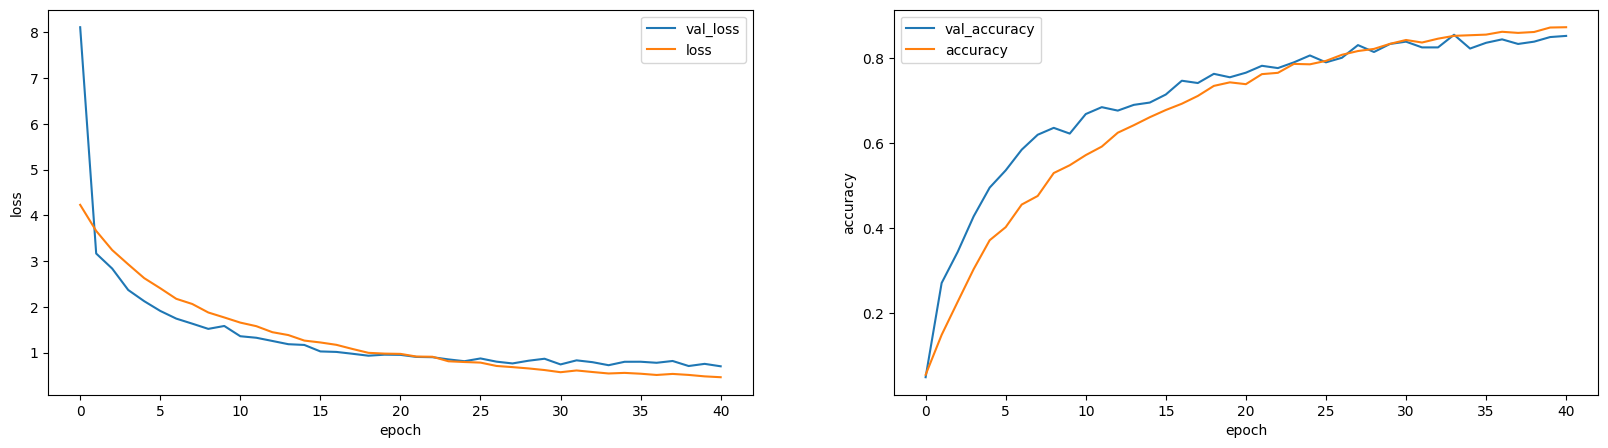

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

axes[0].plot(fit_history.history['val_loss'], label='val_loss')
axes[0].plot(fit_history.history['loss'], label='loss')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[0].legend()

axes[1].plot(fit_history.history['val_accuracy'], label='val_accuracy')
axes[1].plot(fit_history.history['accuracy'], label='accuracy')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
axes[1].legend()

plt.show()

In [22]:
#evaluate the model
eval = model.evaluate(test_generator, verbose=0)
print('Model performance:')
print('loss for test dataset is : {}'.format(eval[0]))
print('accuracy for test dataset is : {}'.format(eval[1]))

Model performance:
loss for test dataset is : 0.7268509268760681
accuracy for test dataset is : 0.8540540337562561


In [23]:
#evaluate the model
eval = model.evaluate(validation_generator, verbose=0)
print('Model performance:')
print('loss for validation dataset is : {}'.format(eval[0]))
print('accuracy for validation dataset is : {}'.format(eval[1]))

Model performance:
loss for validation dataset is : 0.7947248220443726
accuracy for validation dataset is : 0.8366788029670715


1/1 [==============================] - 0s 422ms/step


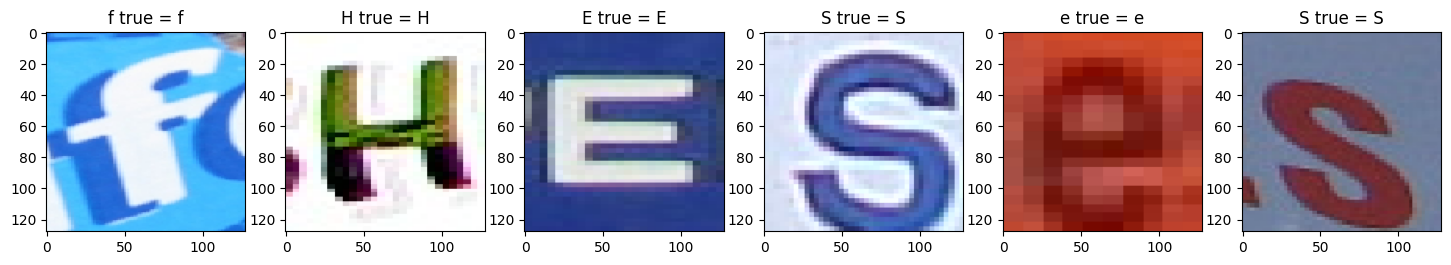

In [24]:
batchX, batchy = validation_generator.next()
pred = model.predict(batchX[0:6])
show_images(batchX[0:6], pred, batchy[0:6])

1/1 [==============================] - 0s 167ms/step


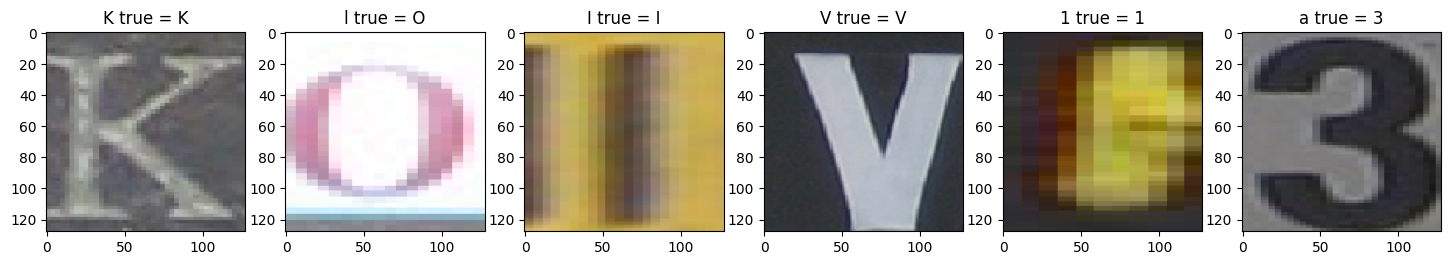

In [25]:
batchX, batchy = validation_generator.next()
pred = model.predict(batchX[0:6])
show_images(batchX[0:6], pred, batchy[0:6])

1/1 [==============================] - 0s 276ms/step


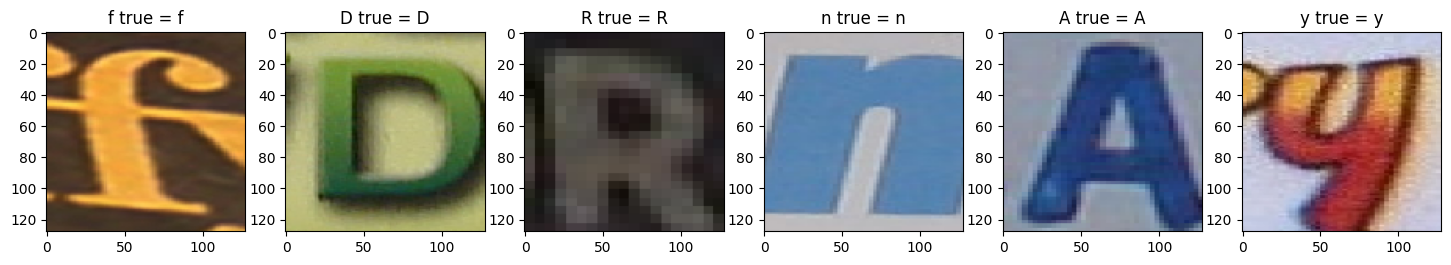

In [26]:
batchX, batchy = validation_generator.next()
pred = model.predict(batchX[0:6])
show_images(batchX[0:6], pred, batchy[0:6])

1/1 [==============================] - 0s 156ms/step


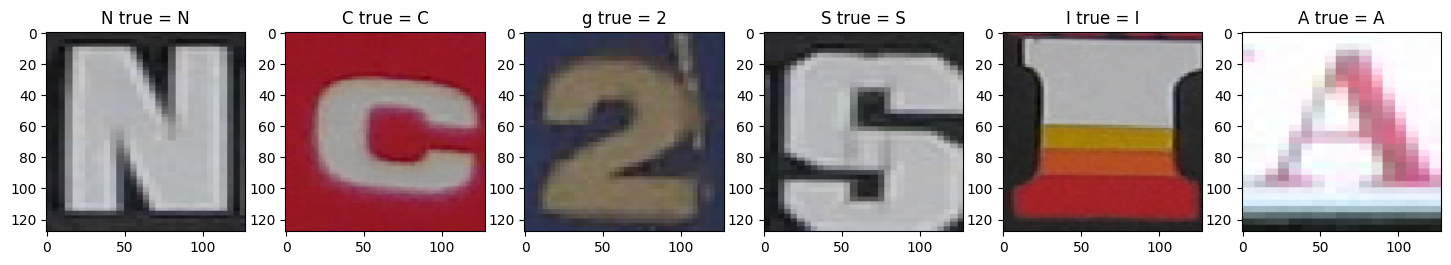

In [27]:
batchX, batchy = validation_generator.next()
pred = model.predict(batchX[0:6])
show_images(batchX[0:6], pred, batchy[0:6])

In [28]:
count = 0
y_true = []
y_preds = []
for _ in range(steps_per_epoch_validation):
    batchX, batchy  = validation_generator.next()
    preds = model.predict(batchX)
    count+=1
    for y, pred in zip(batchy, preds):
        y_true.append(class_name[np.argmax(y)])
        y_preds.append(class_name[np.argmax(pred)])

1/1 [==============================] - 0s 404ms/step


In [29]:
classification_report(y_true, y_preds,zero_division=0)

'              precision    recall  f1-score   support\n\n           0       0.70      0.50      0.58        14\n           1       0.67      0.67      0.67         9\n           2       0.89      0.89      0.89         9\n           3       0.88      1.00      0.93         7\n           4       1.00      0.43      0.60         7\n           5       0.83      0.50      0.62        10\n           6       1.00      0.50      0.67        10\n           7       1.00      0.83      0.91         6\n           8       1.00      0.33      0.50         3\n           9       0.00      0.00      0.00         6\n           A       0.94      0.97      0.96        77\n           B       0.82      0.78      0.80        18\n           C       0.78      0.78      0.78        32\n           D       0.88      0.84      0.86        25\n           E       0.92      0.97      0.94        62\n           F       0.85      0.92      0.88        12\n           G       0.84      0.91      0.87        23\n       

In [30]:
model.save_weights('Char74K.h5')

**Выводы:**
Результат получился достаточно неплохой. В основном ошибки связаны с тем что не корректно определены регистры символов.

Очень низкое к-во имеют модельпоказала для 'w','j','g','9', 'Q'. В остальном качество плучилось очень не плохое.